# Importing library

In [1]:
import re
import pandas as pd
import numpy as np

# ML related
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Add
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers as initializers, regularizers, constraints
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model

Using TensorFlow backend.


# Reading preprocessed data

In [2]:
data = pd.read_pickle("data/preprocessed_data.pkl")

In [3]:
data.head()

,Product,Product Name,Product Link,Image,Brand/Mfr,Short Desc,Longer Desc,Price,Currency,UOM Price,...,Sub category 4,Minor category 4,Category 5,Sub category 5,Minor category 5,Active/Inactive,Creat Date,Last Date Changed,combined_text,category_tree
0,NaN,Eton Soulra XL Solar Panel Dock for iPhone 4 & 4S,http://www.capsells.com/products/eton-soulra-x...,http://www.capsells.com/product_images/g/594/E...,Eton,NaN,With the Eton Soulra XL Solar Panel Dock for i...,261.99,USD,NaN,...,NaN,NaN,NaN,NaN,NaN,Active,16/11/2013,2015-08-12 00:00:00,eton soulra xl solar panel dock for iphone 4 &...,"{1: 'solar', 2: 'solar electronics', 3: 'solar..."
1,NaN,SolarFocus Solar Lighted Cover for the Kindle 4,http://www.capsells.com/products/solarfocus-so...,http://www.capsells.com/product_images/s/229/S...,SolarFocus,NaN,Use the power of the sun to charge your eBook ...,55.99,USD,NaN,...,NaN,NaN,NaN,NaN,NaN,Active,17/11/2013,2015-08-12 00:00:00,solarfocus solar lighted cover for the kindle ...,"{1: 'solar', 2: 'solar electronics', 3: 'solar..."
2,NaN,Go Power Overlander GP-RV-160 RV & Marine Sola...,http://www.capsells.com/products/go-power-over...,http://www.capsells.com/product_images/o/494/O...,Go Power,NaN,The Go Power! Overlander is the largest single...,725.99,USD,NaN,...,NaN,NaN,NaN,NaN,NaN,Active,17/11/2013,2016-04-04 00:00:00,go power overlander gp-rv-160 rv & marine sola...,"{1: 'solar', 2: 'rv & marine', 3: 'rv & marine..."
3,NaN,Solar-Breeze NX Floating Robot Pool Cleaner/Sk...,http://www.capsells.com/solar-breeze-nx-floati...,http://www.capsells.com/product_images/x/972/s...,Solar Breeze,NaN,Key Features:Â Revolutionizes pool cleaning i...,557.00,USD,NaN,...,NaN,NaN,NaN,NaN,NaN,Active,17/11/2013,19/09/2017,solar-breeze nx floating robot pool cleaner/sk...,"{1: 'solar', 2: 'solar pool', 3: 'solar pool p..."
4,NaN,EnergizerÂ® Solarâ„¢ 3 LED Flashlight,http://www.capsells.com/products/energizer-sol...,http://www.capsells.com/product_images/g/079/E...,Energizer,NaN,Whether you've lost power or are simply lookin...,19.99,USD,NaN,...,NaN,NaN,NaN,NaN,NaN,Active,2014-02-01 00:00:00,24/11/2016,energizerâ® solarâ„¢ 3 led flashlight whether ...,"{1: 'solar', 2: 'outdoors', 3: 'solar flashlig..."


In [4]:
category_l1 = []
category_l2 = []
category_l3 = []


for index in range(len(data)):
    
    if type(data['Category 1'][index]) != type(np.nan):
        category_l1.append(data['Category 1'][index].strip().lower())
    else:
        category_l1.append("undefined")

    if type(data['Sub category 1'][index]) != type(np.nan):
        category_l2.append(data['Sub category 1'][index].strip().lower())
    else:
        category_l2.append("undefined")
    if type(data['Minor category 1'][index]) != type(np.nan):
        category_l3.append(data['Minor category 1'][index].strip().lower())
    else: category_l3.append("undefined")

In [5]:
category_l1_tree = {  j:i for i,j in enumerate(list(set(category_l1)))}
category_l2_tree = {  j:i for i,j in enumerate(list(set(category_l2)))}
category_l3_tree = {  j:i for i,j in enumerate(list(set(category_l3)))}

In [6]:
category_l1_tree

{'hybrid': 0,
 'water': 1,
 'solar': 2,
 'engineering\\design': 3,
 'wind': 4,
 'energy management': 5,
 'energy efficiency': 6}

In [7]:
def encode_labels(category_list):
    temp = []
    for i in category_list:
        temp.append()

In [8]:
# category_l3
encoded_category_l1 = [ category_l1_tree[i] for i in category_l1]
encoded_category_l2 =  [ category_l2_tree[i] for i in category_l2]
encoded_category_l3 =  [ category_l3_tree[i] for i in category_l3]

In [9]:
l1s = to_categorical(np.asarray(encoded_category_l1))
l2s = to_categorical(np.asarray(encoded_category_l2))
l3s = to_categorical(np.asarray(encoded_category_l3))

print('Shape of l1 tensor:', l1s.shape)
print('Shape of l2 tensor:', l2s.shape)
print('Shape of l3 tensor:', l3s.shape)

Shape of l1 tensor: (627, 7)
Shape of l2 tensor: (627, 27)
Shape of l3 tensor: (627, 69)


In [10]:
l1_no_of_labels = l1s.shape[1]
l2_no_of_labels = l2s.shape[1]
l3_no_of_labels = l3s.shape[1]

In [11]:
def deep_nlp_model():
    base_output = Input(shape=(256,))
    l1_mlp = Dense(128, activation='relu')(base_output)
    l1_mlp = Dropout(0.5)(l1_mlp)

    l2_mlp = Dense(128, activation='relu')(base_output)
    l2_mlp = Dropout(0.5)(l2_mlp)

    l3_mlp = Dense(128, activation='relu')(base_output)
    l3_mlp = Dropout(0.5)(l3_mlp)


    #Left Message passing block
    #L1 left block
    left_l1_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l1_mlp)
    left_dense_L1 = Dense(128, activation='relu')(left_l1_dense)
    #L2 left block
    left_l2_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l2_mlp)
    left_dense_L1_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(left_dense_L1)
    left_dense_l2_add = Add()([left_l2_dense, left_dense_L1_dense])
    left_dense_L2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(left_dense_l2_add)
    #L3 left block
    left_l3_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l3_mlp)
    left_dense_L2_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(left_dense_L2)
    left_dense_l3_add = Add()([left_l3_dense, left_dense_L2_dense, left_dense_L1_dense])
    left_dense_L3 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(left_dense_l3_add)

    # L3 right block
    right_l3_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l3_mlp)
    right_dense_L3 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(right_l3_dense)
    # L2 right block
    right_l2_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l2_mlp)
    right_dense_L3_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(right_dense_L3)
    right_l2_dense_add = Add()([right_l2_dense, right_dense_L3_dense])
    right_dense_L2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(right_l2_dense_add)
    # L1 right block
    right_l1_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(l1_mlp)
    right_dense_L2_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(right_dense_L2)
    right_l1_dense_add = Add()([right_l1_dense, right_dense_L2_dense, right_dense_L3_dense])
    right_dense_L1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(right_l1_dense_add)


    # Second message passing block
    dense_L1_output_add = Add()([left_dense_L1, right_dense_L1])
    dense_L1_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_L1_output_add)
    dense_L1_output = Dropout(0.3)(dense_L1_output)

    # Second message passing block
    dense_L2_output_add = Add()([left_dense_L2, right_dense_L2])
    dense_L2_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_L2_output_add)
    dense_L2_output = Dropout(0.3)(dense_L2_output)

    # Second message passing block
    dense_L3_output_add = Add()([left_dense_L3, right_dense_L3])
    dense_L3_output = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_L3_output_add)
    dense_L3_output = Dropout(0.3)(dense_L3_output)


    L1_output_predictions = Dense(l1_no_of_labels, activation='softmax', name  = 'L1_output')(dense_L1_output)
    L2_output_predictions = Dense(l2_no_of_labels, activation='softmax', name  = 'L2_output')(dense_L2_output)
    L3_output_predictions = Dense(l3_no_of_labels, activation='softmax', name  = 'L3_output')(dense_L3_output)

    model = Model(input=base_output, outputs=[L1_output_predictions,L2_output_predictions,L3_output_predictions])
    return model


In [12]:
model = deep_nlp_model()
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss={'L1_output': 'categorical_crossentropy', 'L2_output' : 'categorical_crossentropy', 'L3_output' : 'categorical_crossentropy'})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_1[0][0]                    
____________________

/home/opensource/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


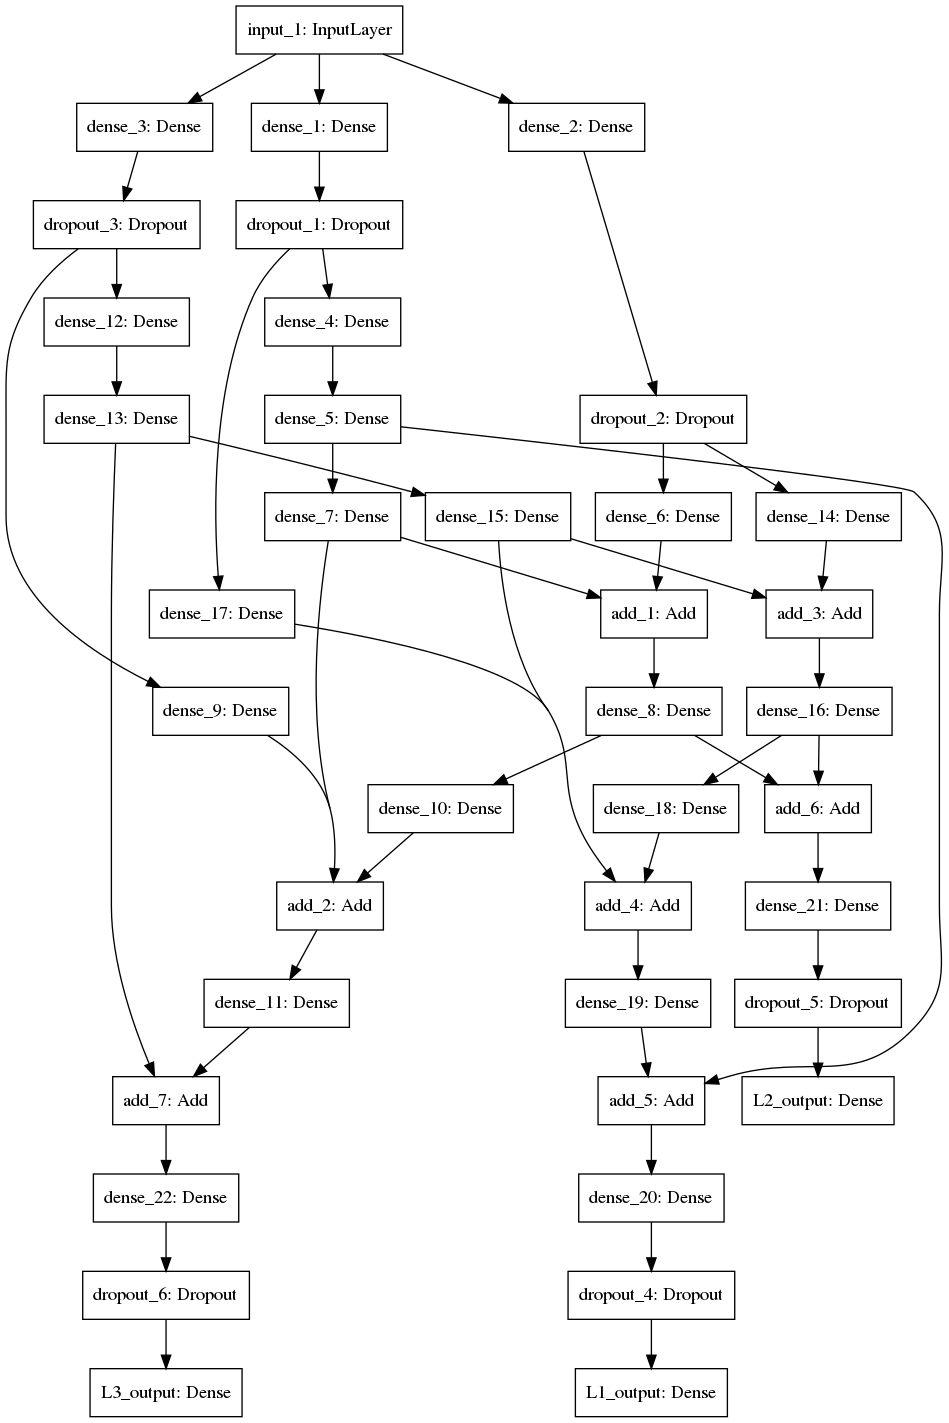

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='deep_nlp_model.png')